This notebook builds on `1_Neural Style Transfer - Baseline.ipynb` by experimenting with different optimizer settings.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

# Getting the Images

In [2]:
# *****************************************************************************
# To get this code to work on your system, you may need to re-write this cell,
# depending on where you plan to run these files from. As you can see, I chose
# to put the files on my Google Drive and run them from there using Google
# Colab. You may choose another approach, such as running files locally.
# *****************************************************************************
from google.colab import drive
drive.mount('/content/drive')

base_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/Hinton.jpg"
style_image_path = "/content/drive/MyDrive/Colab Notebooks/CSCI_S-89/Final_Project/Images/GeorgeFloyd.jpg"

Mounted at /content/drive


In [3]:
# Make sure the images are a similar size. Widely differing sizes can make the
# style transfer more difficult.
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

In [4]:
# Opens, reizes, and converts an image into a numpy array.
def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Transform the the array (for use with VGG19 ImageNet).
    img = keras.applications.vgg19.preprocess_input(img)
    return img

# Converts a numpy array back into an image.
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    # Zero-center the values by removing the ImageNet mean pixel values.
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # Convert the images from BGR to RGB.
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [5]:
base_image = preprocess_image(base_image_path)
style_image = preprocess_image(style_image_path)

# Make sure that the tensor for the generated image can be changed.
generated_image = tf.Variable(preprocess_image(base_image_path))

# Setting up the Network

In [6]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# Choosing the Content and Style Layers

In [7]:
content_layer_name = "block5_conv2"

style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

# Defining the Loss Functions

In [8]:
content_weight = 2.5e-8
style_weight = 1e-6
total_variation_weight = 1e-6

def content_loss(base_img, generated_img):
    # Compute the mean squared error between the two images.
    return tf.reduce_sum(tf.square(generated_img - base_img))

def gram_matrix(x):
    # Compute the Gram matrix.
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, generated_img):
    # Compute the Gram matrices of the style and combination images.
    S = gram_matrix(style_img)
    C = gram_matrix(generated_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    # Compute the total variation loss, which operates on the generated image.
    a = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
    b = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

def compute_loss(generated_image, base_image, style_image):
    input_tensor = tf.concat([base_image, style_image, generated_image], axis=0)
    features = feature_extractor(input_tensor)

    # Initialize the loss to zero.
    loss = tf.zeros(shape=())

    # Add the content loss.
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    generated_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, generated_features)

    # Add the style loss.
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        generated_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(style_features, generated_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    # Add the total variation loss.
    loss += total_variation_weight * total_variation_loss(generated_image)
    return loss

## Stochastic Gradient Descent

### Stochastic Gradient Descent, learning rate=100

array([[[251, 246, 234],
        [245, 240, 235],
        [249, 244, 249],
        ...,
        [246, 248, 239],
        [253, 249, 232],
        [255, 255, 241]],

       [[250, 248, 230],
        [241, 240, 230],
        [247, 243, 245],
        ...,
        [243, 254, 235],
        [247, 249, 224],
        [255, 255, 227]],

       [[249, 252, 225],
        [241, 243, 225],
        [246, 244, 240],
        ...,
        [237, 255, 231],
        [240, 253, 219],
        [251, 255, 222]],

       ...,

       [[  0,   0,  16],
        [  0,   0,  11],
        [  0,   0,   3],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   2],
        [  0,   0,   0],
        [  0,   0,  12],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,  42],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
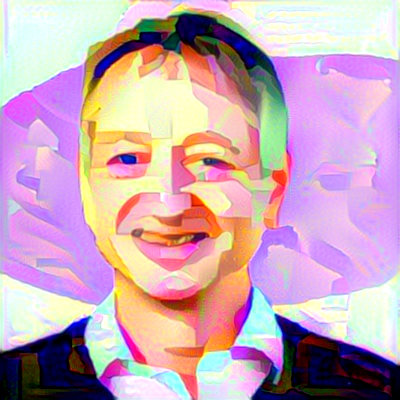

Train step: 4000


In [9]:
@tf.function
def compute_loss_and_grads(generated_image, base_image, style_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, base_image, style_image)
    grads = tape.gradient(loss, generated_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

This generated image has been created using the settings that Chollet chose. It will as as a baseline image, fom which we will try to improve. We will start by experimenting with the choice of optimizer, as well as the optimizer settings.

To start with, let's try SGD with a smaller learning rate. I must admit that I was surprised to see Chollet's choice of 100 for the learning rate. It seems so high. Let's try a smaller setting and see how it looks. We will keep the same decay settings, but let's add some momentum.

### Stochastic Gradient Descent, learning rate=10

array([[[253, 255, 252],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 254]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 253],
        [255, 255, 255],
        [251, 255, 247],
        ...,
        [255, 255, 253],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  3,   0,   4],
        ...,
        [  2,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  1,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  5,   0,   3],
        [  3,   0,   1],
        [  2,   0,   1],
        ...,
        [  1,   0,   0],
        [  0,   0,   0],
        [  1,   0,   0]]], dtype=uint8)
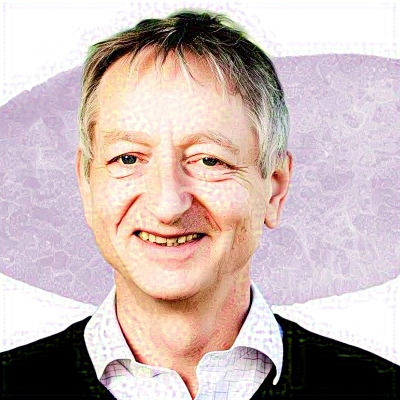

Train step: 4000


In [10]:
optimizer = keras.optimizers.SGD(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=10, decay_steps=100, decay_rate=0.96
    ),
    momentum=0.9
)

generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

Well, that didn't work out at all. Okay, let's try a different optimizer. We will first try the Adam optimizer with what looks like a reasonable set of initial settings.

## Adam, learning rate=0.001

array([[[254, 254, 254],
        [255, 255, 254],
        [255, 255, 254],
        ...,
        [255, 255, 254],
        [254, 254, 254],
        [253, 254, 253]],

       [[255, 255, 254],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 254],
        [255, 255, 255],
        [255, 255, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  1,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  1,   0,   1],
        [  1,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  1,   0,   0]]], dtype=uint8)
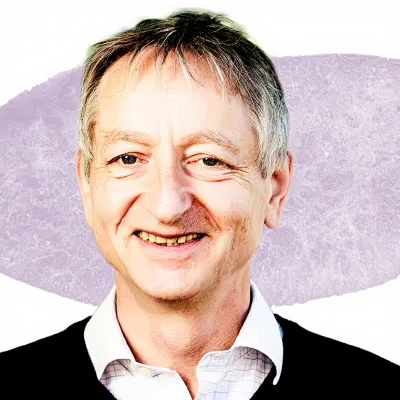

Train step: 4000


In [11]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-1)

generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

Okay, perhaps I choose too small a learning rate. Let's try again, this time with a bigger learning rate.

## Adam, learning rate=0.01

array([[[250, 250, 246],
        [255, 255, 249],
        [255, 255, 248],
        ...,
        [255, 255, 247],
        [253, 248, 244],
        [251, 246, 246]],

       [[255, 255, 248],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 251]],

       [[255, 255, 247],
        [255, 255, 255],
        [255, 255, 249],
        ...,
        [255, 255, 253],
        [255, 255, 255],
        [255, 255, 250]],

       ...,

       [[  4,   0,   0],
        [  0,   0,   0],
        [  5,   0,   0],
        ...,
        [  9,   0,  10],
        [  0,   0,   0],
        [  1,   0,   0]],

       [[ 12,   0,   5],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  3,   0,   0]],

       [[ 14,   0,  10],
        [  9,   0,   2],
        [  5,   0,   0],
        ...,
        [  7,   0,   3],
        [  6,   0,   1],
        [ 11,   0,   8]]], dtype=uint8)
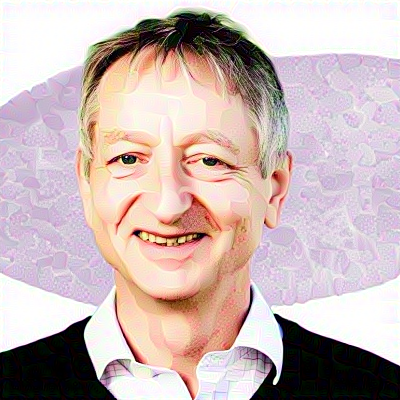

Train step: 4000


In [12]:
optimizer = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.99, beta_2=0.999, epsilon=1e-1)

generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

That's a bit better, and it looks nicer than the image generated with the Stochastic Gradient Descent optimizer. The structure of the face is better preserved, but we need something closer to the straight lines in the style image. Let's try the combination of a more aggressive learning rate (0.1) together with an exponential decay schedule to gradually reduce the learning rate over time.

## Adam, learning rate=0.1, decay

array([[[252, 250, 242],
        [255, 255, 246],
        [255, 255, 247],
        ...,
        [255, 255, 247],
        [255, 255, 246],
        [254, 254, 248]],

       [[255, 255, 241],
        [255, 255, 248],
        [255, 255, 246],
        ...,
        [255, 255, 253],
        [255, 255, 254],
        [255, 255, 249]],

       [[255, 255, 240],
        [255, 255, 239],
        [255, 255, 232],
        ...,
        [255, 255, 240],
        [255, 255, 249],
        [255, 255, 247]],

       ...,

       [[ 12,   0,   0],
        [  0,   0,   0],
        [ 10,   0,   8],
        ...,
        [  0,   0,   8],
        [  0,   0,   0],
        [ 10,   0,  12]],

       [[ 18,   0,   3],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  6,   0,   5]],

       [[ 18,   0,  10],
        [ 13,   0,   2],
        [  4,   0,   0],
        ...,
        [ 16,   0,  12],
        [  7,   0,   4],
        [ 12,   0,  10]]], dtype=uint8)
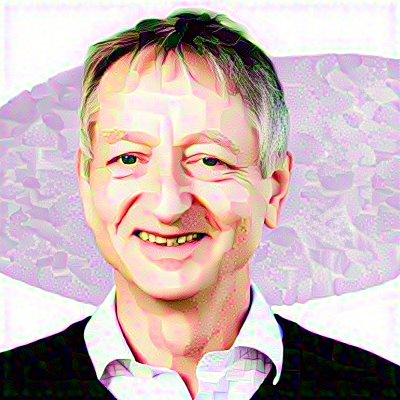

Train step: 4000


In [13]:
from keras.optimizers.schedules import ExponentialDecay

optimizer = keras.optimizers.Adam(
    learning_rate=ExponentialDecay(initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96),
    beta_1=0.99,
    beta_2=0.999,
    epsilon=1e-1
)

generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

That's a little bit better again. There's a more definition for the different straight line sections of the face. Let's try again, this time with an even bigger learning rate.

## Adam, learning rate=0.75, decay

array([[[255, 255, 245],
        [255, 255, 242],
        [255, 255, 247],
        ...,
        [255, 255, 244],
        [255, 255, 248],
        [255, 255, 255]],

       [[255, 255, 239],
        [255, 255, 233],
        [255, 255, 235],
        ...,
        [255, 255, 237],
        [255, 255, 240],
        [255, 255, 250]],

       [[255, 255, 237],
        [255, 255, 224],
        [255, 255, 224],
        ...,
        [255, 255, 227],
        [255, 255, 234],
        [255, 255, 247]],

       ...,

       [[ 15,   0,   0],
        [  1,   0,   0],
        [ 22,   0,  11],
        ...,
        [  6,   0,  11],
        [  0,   0,   3],
        [  4,   0,   4]],

       [[ 14,   0,   0],
        [  1,   0,   0],
        [ 11,   0,   0],
        ...,
        [  9,   0,  11],
        [  0,   0,   0],
        [  2,   0,   2]],

       [[ 11,   0,   2],
        [  6,   0,   0],
        [  8,   0,   0],
        ...,
        [ 13,   0,  11],
        [  3,   0,   3],
        [  1,   0,   1]]], dtype=uint8)
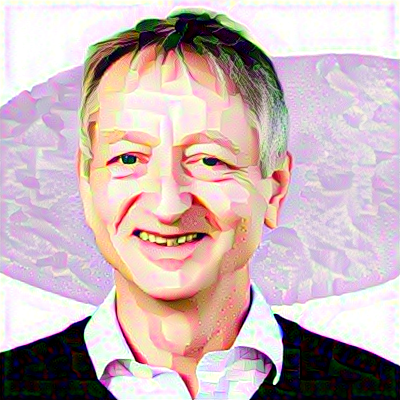

Train step: 4000


In [14]:
optimizer = keras.optimizers.Adam(
    learning_rate=ExponentialDecay(initial_learning_rate=0.75, decay_steps=100, decay_rate=0.9),
    beta_1=0.99,
    beta_2=0.999,
    epsilon=1e-1
)

generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

This is slightly better again. It's subtle, but there is a little more definition. I suspect we are close to the limit on improving thusing Adam optimizationis, and there is no sign of the colors from the style image coming through. Let's try another optimizer.

## RMSProp, learning rate=0.01, decay

Let's try RMSProp optimization, with a learning rate of 0.01 together with an exponential decay schedule.

array([[[255, 241, 235],
        [255, 255, 235],
        [255, 255, 236],
        ...,
        [255, 255, 239],
        [255, 248, 243],
        [255, 246, 244]],

       [[255, 255, 236],
        [255, 255, 250],
        [255, 255, 250],
        ...,
        [255, 255, 255],
        [255, 255, 254],
        [255, 255, 238]],

       [[255, 255, 236],
        [255, 255, 239],
        [255, 255, 235],
        ...,
        [255, 255, 243],
        [255, 255, 246],
        [255, 255, 238]],

       ...,

       [[ 17,   0,   0],
        [  0,   0,   0],
        [ 16,   0,   0],
        ...,
        [  8,   0,  19],
        [  0,   0,   0],
        [ 12,   0,   4]],

       [[ 19,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [ 17,   0,   3]],

       [[ 19,   0,  13],
        [ 13,   0,   0],
        [ 19,   0,   0],
        ...,
        [ 19,   0,  15],
        [ 19,   0,   6],
        [ 19,   0,  18]]], dtype=uint8)
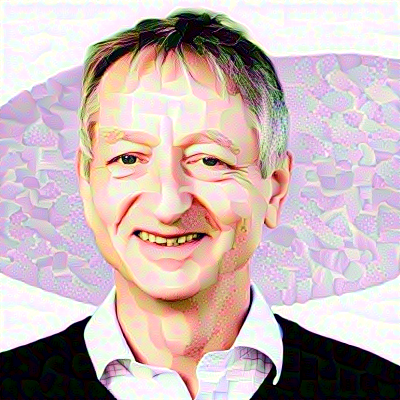

Train step: 4000


In [15]:
optimizer = keras.optimizers.RMSprop(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=100, decay_rate=0.96
    ),
    rho=0.9,
    epsilon=1e-7
)

generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

Interestingly, this generated image is very similar to the generated image for the Adam optimizer run with a learning rate of 0.75. But here, we are using an RMSProp optimizer with a earning rate of only 0.01. Let's see what it looks like with RMSProp optimization and a higher learning rate.

## RMSProp, learning rate=0.1, decay

array([[[246, 255, 255],
        [233, 255, 255],
        [228, 255, 254],
        ...,
        [237, 255, 251],
        [255, 255, 255],
        [255, 255, 255]],

       [[235, 255, 255],
        [221, 255, 255],
        [226, 255, 246],
        ...,
        [229, 255, 244],
        [248, 255, 253],
        [255, 255, 255]],

       [[234, 255, 255],
        [223, 255, 248],
        [231, 255, 236],
        ...,
        [228, 255, 241],
        [237, 255, 243],
        [246, 255, 249]],

       ...,

       [[  0,   0,  42],
        [  0,   0,  46],
        [  0,   0,  54],
        ...,
        [  0,   0,  70],
        [  0,   0,  86],
        [  0,   0, 100]],

       [[  0,   0,  41],
        [  0,   0,  44],
        [  0,   0,  65],
        ...,
        [  0,   0,  90],
        [  0,   0,  97],
        [  0,   0,  83]],

       [[  0,   0,  41],
        [  0,   0,  28],
        [  0,   0,  69],
        ...,
        [  0,   0, 105],
        [  0,   0,  99],
        [  0,   0,   0]]], dtype=uint8)
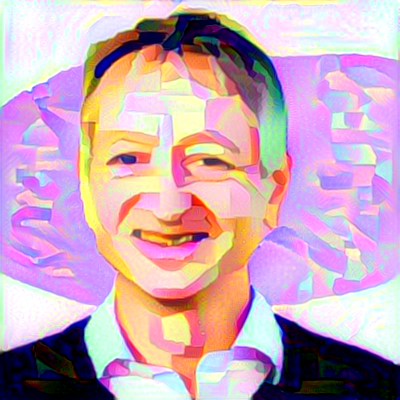

Train step: 4000


In [16]:
optimizer = keras.optimizers.RMSprop(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96
    ),
    rho=0.9,
    epsilon=1e-7
)

generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

Okay, that's a bit more like it. We're starting to get more elements from the style image coming through. This is better than our baseline image because the elements of the style image are a little more pronounced. For example, look at the forehead.

Let's see if increasing the learning rate to 0.5 continues the improvement...

## RMSProp, learning rate=0.5, decay

array([[[183, 255, 221],
        [179, 255, 218],
        [189, 255, 228],
        ...,
        [168, 255, 196],
        [169, 255, 186],
        [174, 255, 183]],

       [[181, 255, 219],
        [181, 255, 215],
        [192, 255, 225],
        ...,
        [172, 255, 196],
        [166, 255, 183],
        [168, 255, 176]],

       [[187, 255, 222],
        [187, 255, 216],
        [200, 255, 223],
        ...,
        [176, 255, 197],
        [167, 255, 186],
        [169, 255, 182]],

       ...,

       [[  0,   0,  65],
        [  0,   0,  65],
        [  0,   0,  60],
        ...,
        [  0,   0,  22],
        [  0,   0,  26],
        [  0,   0,  26]],

       [[  0,   0,  64],
        [  0,   0,  70],
        [  0,   0,  77],
        ...,
        [  0,   0,  26],
        [  0,   0,  33],
        [  0,   0,  40]],

       [[  0,   0,  57],
        [  0,   0,  69],
        [  0,   0,  88],
        ...,
        [  0,   0,  29],
        [  0,   0,  38],
        [  0,   0,   0]]], dtype=uint8)
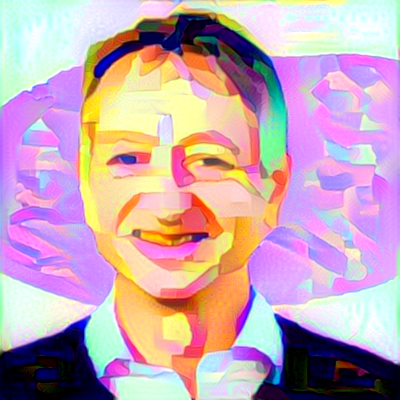

Train step: 4000


In [17]:
optimizer = keras.optimizers.RMSprop(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.5, decay_steps=100, decay_rate=0.96
    ),
    rho=0.9,
    epsilon=1e-7
)

generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

This image is actually not as good as the previous one (RMSProp, learning rate=0.1, decay). Some elements of the style are getting washed out in this image.

It looks like we've found the bounds on RMSProp optimization. Let's try another optimizer. Nadam combines the best features of Adam and RMSprop. Let's give it a spin...

## Nadam, learning rate=0.01, decay

array([[[255, 241, 241],
        [255, 255, 238],
        [255, 255, 239],
        ...,
        [252, 255, 240],
        [252, 251, 244],
        [253, 251, 247]],

       [[255, 255, 236],
        [255, 255, 249],
        [255, 255, 249],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 237],
        [255, 255, 244],
        [255, 255, 242],
        ...,
        [255, 255, 248],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 15,   0,   0],
        [  0,   0,   0],
        [ 15,   0,   0],
        ...,
        [  7,   0,  17],
        [  0,   0,   5],
        [ 14,   0,  12]],

       [[ 13,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [ 15,   0,   9]],

       [[ 12,  13,   8],
        [ 12,   0,   0],
        [ 14,   0,   0],
        ...,
        [ 15,   0,  19],
        [ 17,   0,  15],
        [ 14,   0,  16]]], dtype=uint8)
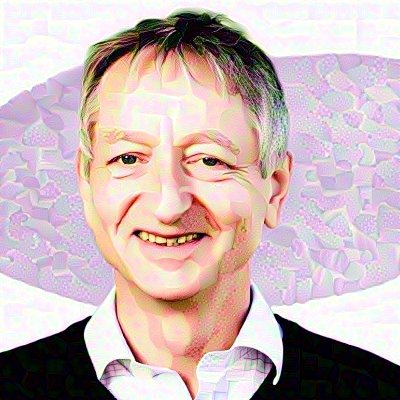

Train step: 4000


In [18]:
optimizer = keras.optimizers.Nadam(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=100, decay_rate=0.96
    ),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

Okay, it looks like we need to increase the learning rate.

## Nadam, learning rate=0.1, decay

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 254],
        ...,
        [255, 255, 252],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 248],
        ...,
        [255, 255, 252],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 249],
        [255, 255, 253],
        [253, 255, 240],
        ...,
        [255, 255, 250],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[  6,   0,   0],
        [  0,   0,   0],
        [  0,   0,   5],
        ...,
        [  0,   0,  29],
        [  0,   0,  14],
        [  8,   0,  17]],

       [[  1,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,  22],
        [  0,   0,   8],
        [  0,   0,   2]],

       [[ 11,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,  36],
        [  3,   0,  22],
        [  0,   0,   0]]], dtype=uint8)
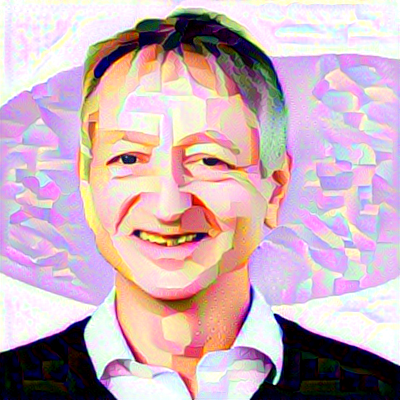

Train step: 4000


In [19]:
optimizer = keras.optimizers.Nadam(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1, decay_steps=100, decay_rate=0.96
    ),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

That's pretty good, but if you look closely it's still not as good as RMSProp with a learning rate of 0.1. Let's try increasing the learning rate again...

## Nadam, learning rate=0.5, decay

array([[[242, 255, 255],
        [233, 255, 247],
        [235, 255, 243],
        ...,
        [243, 255, 240],
        [255, 255, 252],
        [255, 255, 255]],

       [[239, 255, 253],
        [236, 255, 243],
        [238, 255, 238],
        ...,
        [245, 255, 235],
        [255, 255, 240],
        [255, 255, 245]],

       [[236, 255, 250],
        [233, 255, 240],
        [237, 255, 233],
        ...,
        [243, 255, 229],
        [250, 255, 232],
        [255, 255, 239]],

       ...,

       [[  0,   0,   8],
        [  0,   0,   6],
        [  0,   0,  24],
        ...,
        [  0,   0,  57],
        [  0,   0,  73],
        [  0,   0,  89]],

       [[  0,   0,   7],
        [  0,   0,   1],
        [  0,   0,  24],
        ...,
        [  0,   0,  71],
        [  0,   0,  79],
        [  0,   0,  72]],

       [[  0,   0,   8],
        [  0,   0,   0],
        [  0,   0,  25],
        ...,
        [  0,   0,  91],
        [  0,   0,  91],
        [  0,   0,  10]]], dtype=uint8)
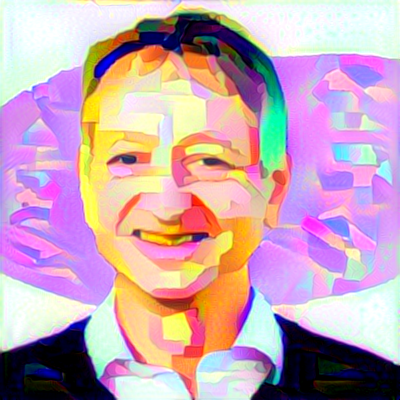

Train step: 4000


In [20]:
optimizer = keras.optimizers.Nadam(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.5, decay_steps=100, decay_rate=0.96
    ),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, base_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(generated_image.numpy())
        display.clear_output(wait=True)
        display.display(img)
        print("Train step: {}".format(i))

This is quite good. In my opinion, it rivals the generated image using RMSProp with a learning rate of 0.1. However, if you look very closely, there are slightly sharper lines and bettwer color contrasts  the image generated using RMSProp with a learning rate of 0.1.